# Counting Molecular Complexes
(c) 2020 The Authors. All creative work is published under a [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) permissive license. All software is released under a standard [MIT](https://opensource.org/licenses/MIT) license. **This software is provided as-is and may be subject to change.**

In [1]:
import numpy as np
import pandas as pd
import panel as pn 
import altair as alt
import tqdm
import prot.viz
prot.viz.altair_theme()
pn.extension('vega')
_ = alt.data_transformers.enable('default')

In this notebook, we provide a series of estimates for the copy numbers of various protein complexes that would be needed for a bacterium to double in the typical doubling time of $\approx$ 3000 seconds. Everything presented here is provisional and may be entirely wrong. 

All plots in this notebook are interactive -- you can zoom, pan, and hover over points to get more information about their identity. 

## Summary of Data
Nathan and I have spent the past few months assembling, curating, and evaluating an array of proteomic measurements of *E. coli* across a wide variety of growth conditions. After examining ~10 unique data sets, 4 met our criterion for being "valid" data sets. This means that a) the numbers reported by the authors are in "absolute units" meaning actual approximate number of proteins per cell and b) their supplemental information thoroughly described their quantitation procedure such that values from one data set to another could be manipulated into a form that is directly comparable. Nathan and I are working on an auxiliary document that throughly describes our curation procedure and briefly summarizes each data set. The four data sets we settled on using are described in the table below:

| **Title** | **Author** | **Year** | **Number of unique proteins measured** | **Experimental Method**| 
|:--:|:--:|:--:|:--:|:--:|
| [The quantitative and condition-dependent *E. coli* proteome](https://www.nature.com/articles/nbt.3418) | Alexander Schmidt, ($\dots$), Matthias Heinemann | 2016 |  2,054 | Mass Spectrometry| 
| [Proteome reallocation in *E. coli* with increasing specific growth rate](https://pubs.rsc.org/en/content/articlelanding/2015/mb/c4mb00721b/unauth#!divAbstract) | Karl Peebo, ($\dots$), Raivo Vilu | 2015| 1,525 | Mass Spectrometry |
| [Quantifying absolute protein synthesis rates reveals principles underlying allocation of cellular resources](https://www.cell.com/cell/fulltext/S0092-8674(14)00232-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867414002323%3Fshowall%3Dtrue) | Gene Wei Li, ($\dots$), Jonathan Weissman | 2014 | 3,041 | Ribosomal Profiling |
| [*E. coli* achieves faster growth by increasing catalytic translation rates of proteins](https://www.nature.com/articles/s41467-019-13483-w) | Kaspar Valgepea, ($\dots$), Raivo Vilu | 2013 | 1,185 | Mass Spectrometry| 

With this collection of data, we scraped the [EcoCyc](https://ecocyc.org/) database to assign annotation to each gene along with a variety of identifiers and classifications of function. After all is said-and-done, our compiled data set includes measurements of 3442 unique proteins across 36 unique growth conditions. To our knowledge, this is the most comprehensive quantitative assembly of proteomic measurements of *E. coli* across growth rates which vary by one order of magnitude.  

In addition to individual gene annotations, we compiled a list of all known protein and protein-RNA complexes in *E. coli* whose subunit composition has been experimentally verified. Given our proteomic measurements, we calculated the total number of unique *units* that could be formed for each protein. For example, consider the F1 ATP Synthase Complex. The stoichiometry of this complex (in terms of protein subunits) can be written as follows:

$$
[\text{AtpC}]_1[\text{AtpH}]_1[\text{AtpA}]_3[\text{AtpG}]_1[\text{AtpD}]_3
$$

where the subscript denotes the copy number of each protein in the complex. We will examine this complex in depth further on in this notebook, but lets assume that in our measurements, we observe $n$ copies of each protein listed in the stoichiometric equation above. The total number of functional units that can be assembled can then be calculated as 

$$
N_\text{units} = \frac{n_\text{observed}}{n_\text{annotated}}. \tag{1}
$$

Thus, the *maximum* number of assembled complexes corresponds to the *minimum* number of functional units possible given measurements of the individual constituents.

This would be an easy calculation to make assuming we had infinite precision in the measurements made by mass spectrometry. However, the extraction efficiency of proteins can be highly variable depending on their localization and the technique used by the researchers. This means that occasionally, some subunits may not be extracted as efficiently as other subunits in the same complex. Rather than relying on the minimum number of functional units observed for each subunit, we compute the *average* number of functional subunits across all subunits in the complex,

$$
N_\text{complexes} = {1 \over N_\text{subunits in complex}}\sum\limits_i {n_\text{observed}^{(i)} \over n^{(i)}_\text{annotated}}. \tag{2}
$$

We believe that this averaging presents a realistic view of the total number of assembled complexes present per cell. 

## Introducing the Data Sets
Where are my manners? Lets first meet the data before we explore the protein complex copy numbers. While the data sets described in the table above only cover at best ~ 60% of the total number of annotated genes in *E. coli*, they represent far-and-away the vast majority of the mass of the proteome across all conditions. This can be seen below where the total mass of the proteome (in fg / cell) is plotted as a function of the growth rate for each data set.

In [2]:
# Load the compiled data 
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')

# Shrink the data set before encoding to save some space.
tot_prot_mass = data.groupby(['dataset_name', 'condition', 'growth_rate_hr'])['fg_per_cell'].sum().reset_index()

# Set up the base plot
total_base = alt.Chart(tot_prot_mass)

# Encode the data
total_plot = total_base.mark_point(size=80).encode(
                x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
                y=alt.Y('fg_per_cell:Q', axis={'title':'protein mass per cell [fg]'}),
                fill=alt.Color('dataset_name:N', legend={'title':'data set'}),
                shape='dataset_name:N',
                tooltip=['condition', 'dataset_name', 'growth_rate_hr', 'fg_per_cell:Q', 'tot_per_cell:Q'],
                strokeWidth=alt.value(0.5)
            ).interactive(
            ).properties(
                title='total protein mass per cell'
            )

# Display
total_plot


This plot illustrates that all of the data sets combined fall on approximately the same line. This illustrates that, between the different data sets, the majority of the  proteome mass is measured in all cases. We can break this down further and examine the total mass of different segments of the proteome, broken down by their Cluster of Orthologous Group (COG) annotation. 

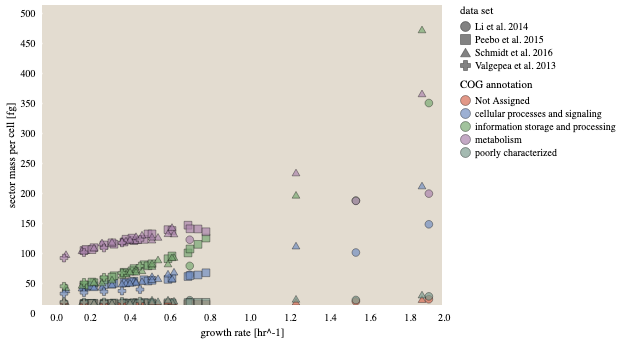

In [3]:
# Compute the sum total mass per sector
cog_mass_data = data.groupby(['dataset_name', 'condition', 'cog_class', 'growth_rate_hr'])['fg_per_cell'].sum().reset_index()

# Set up the base plot.
base = alt.Chart(cog_mass_data)

# Encode the data. 
plot = base.mark_point(size=60).encode(
            x = alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y = alt.Y('fg_per_cell:Q', axis={'title':'sector mass per cell [fg]'}),
            fill=alt.Color('cog_class:N', legend={'title':'COG annotation'}),
            shape=alt.Shape('dataset_name:N', legend={'title':'data set'}),
            strokeWidth=alt.value(0.5)
        ).interactive()
plot

Even across different breakdowns of the proteome, we can see that the various data sets fall in close agreement with the total mass of each sector. Rather than considering only the total mass per cell of each sector, we can easily compute the *fraction* of the proteome devoted to each COG class. 

In [4]:
# Compute the mass fraction
mass_frac = []
for g, d in data.groupby(['dataset', 'condition', 'growth_rate_hr']):
    tot_mass = d['fg_per_cell'].sum()
    sector_mass = d.groupby(['dataset', 'dataset_name', 'condition', 'growth_rate_hr', 'cog_class'])['fg_per_cell'].sum().reset_index()
    frac = sector_mass['fg_per_cell'].values / tot_mass
    sector_mass['frac'] = frac
    mass_frac.append(sector_mass)
mass_frac = pd.concat(mass_frac, sort=False)


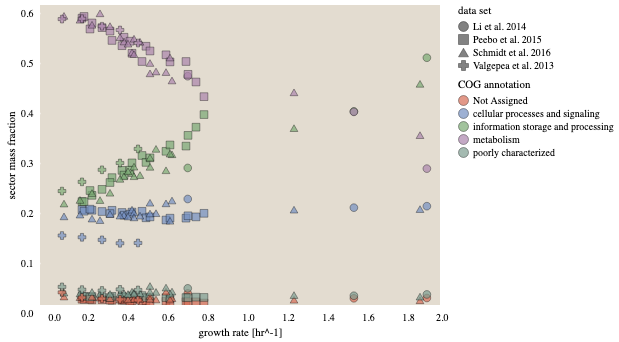

In [5]:
# Set up the base plot.
base = alt.Chart(mass_frac)

# Encode the data. 
plot = base.mark_point(size=60).encode(
            x = alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y = alt.Y('frac:Q', axis={'title':'sector mass fraction'}),
            fill=alt.Color('cog_class:N', legend={'title':'COG annotation'}),
            shape=alt.Shape('dataset_name:N', legend={'title':'data set'}),
            strokeWidth=alt.value(0.5)
        ).interactive()
plot

The plot above reveals that the sectors devoted to metabolism (purple) and information storage & processing (green) have the strongest dependence on the grwoth rate and are anti-correlated with one another. The other sectors appear more-or-less independent of growth rate. To quantify the relationship between the information storage & processing and metabolism sectors, we can plot the mass fraction of one against the other, and color the points by growth rate. 

In [6]:
# Compute the correlation dataframe. 
info_metab_corr = pd.DataFrame([])
for g, d in mass_frac.groupby(['dataset_name', 'condition', 'growth_rate_hr']):
    metab = d[d['cog_class']=='metabolism']['frac'].values[0]
    info = d[d['cog_class'].str.contains('information')]['frac'].values[0]
    info_metab_corr = info_metab_corr.append({'dataset_name':g[0],
                                              'condition':g[1],
                                              'growth_rate_hr':g[2],
                                              'info_frac':info,
                                              'metab_frac':metab}, 
                                            ignore_index=True)

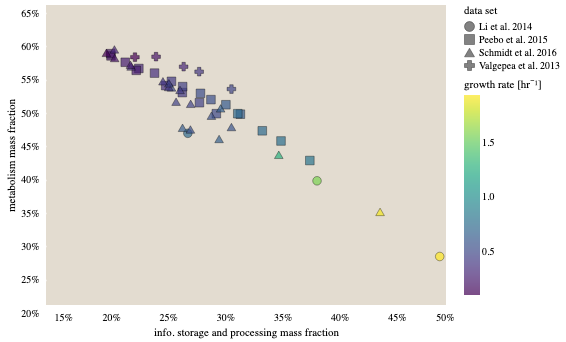

In [7]:
# Define the defaults
defaults =  {'fill':alt.Color('growth_rate_hr:Q', scale=alt.Scale(scheme='viridis'), legend=alt.Legend(title='growth rate [hr\u207b\u00b9]'))}
base = alt.Chart(info_metab_corr)
base.mark_point(size=75).encode(
            x=alt.X('info_frac:Q', 
                    axis=alt.Axis(format='%', title='info. storage and processing mass fraction'),
                   scale=alt.Scale(domain=[0.15, 0.5])),
            y=alt.Y('metab_frac:Q', 
                    axis=alt.Axis(format='%', title='metabolism mass fraction'),
                   scale=alt.Scale(domain=[0.2, 0.65])),
            shape=alt.Shape('dataset_name:O', legend={'title':'data set'}),
            strokeWidth=alt.value(0.5),
            **defaults
        ).interactive()

In [8]:
# Load the complex subunit counts. 
subunits = pd.read_csv('../../data/compiled_annotated_complexes.csv')

# Load the compiled data 
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')
data['gene_name'] = data['gene_name'].str.lower()

# Compute the minimum number of complexes. 
complex_count = subunits.groupby(['dataset', 'dataset_name', 'condition', 'growth_rate_hr', 'complex_annotation', 'complex'])['n_units'].mean().reset_index()

In [9]:
complex_count.sort_values(by='complex_annotation', inplace=True)
selector = pn.widgets.Select(name='annotated complex', options=list(complex_count['complex_annotation'].unique()), value='1-PFK')
@pn.depends(cplx=selector.param.value)
def plot_cplx(cplx):
    sel_cplx = complex_count[complex_count['complex_annotation']==cplx]
    chart = alt.Chart(sel_cplx, width=500, height=250).mark_point(size=40).encode(
        x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
        y=alt.Y('n_units:Q', axis={'title':'minimimum copy number'}),
        fill='dataset_name:N',
        stroke=alt.value('black'),
        strokeWidth=alt.value(0.2),
        tooltip=['condition'] 
    ).properties(title=cplx.replace('&alpha;', 'α').replace('&beta;', 'β')).interactive()
    return chart

pn.Column(selector, plot_cplx)

Column
    [0] Select(name='annotated complex', options=['&alpha;-dehydro-&beta;-d...], value='&alpha;-dehydro-&beta;-de...)
    [1] ParamFunction(function)

## DNA Polymerase

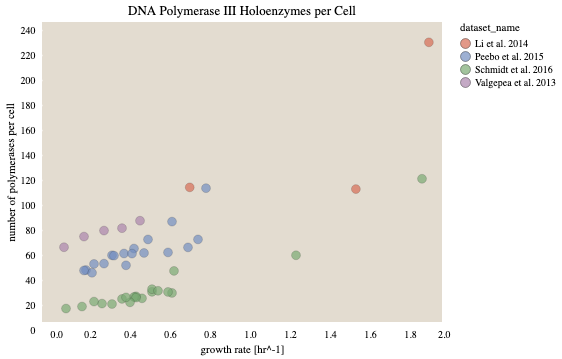

In [10]:
complexes = ['CPLX0-3803']
dna_pol = complex_count[complex_count['complex'].isin(complexes)]
base = alt.Chart(dna_pol)
individuals = base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of polymerases per cell'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='DNA Polymerase III Holoenzymes per Cell')
individuals.save('../../figures/dna_pol.html')
individuals

## RNA Polymerase

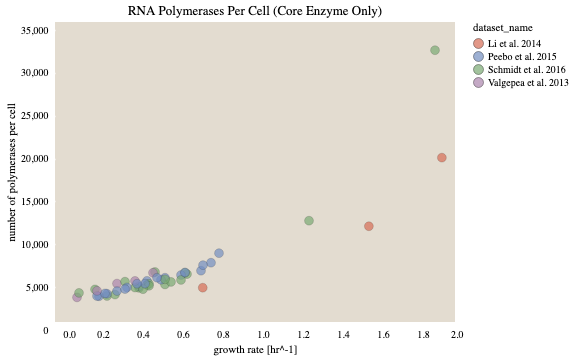

In [11]:
complexes = ['APORNAP-CPLX']
rna_pol = complex_count[complex_count['complex'].isin(complexes)]
base = alt.Chart(rna_pol)
individuals = base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of polymerases per cell'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='RNA Polymerases Per Cell (Core Enzyme Only)')
individuals.save('../../figures/rnap.html')
individuals

## ATP Synthesis 

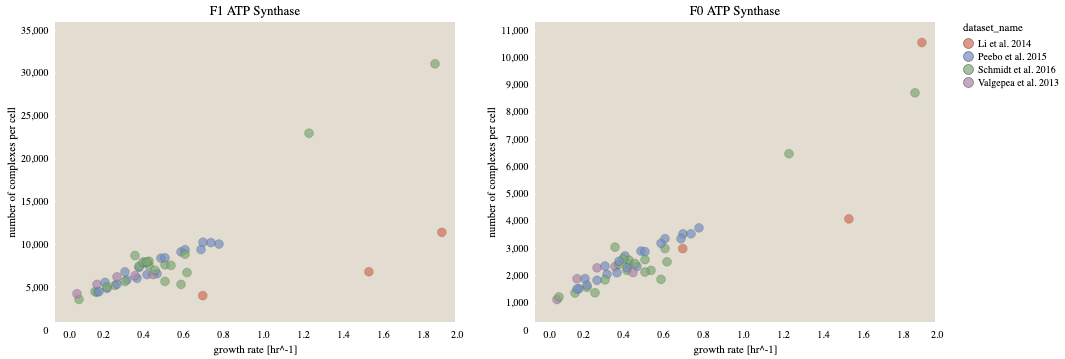

In [12]:
complexes = ['F-1-CPLX', 'F-O-CPLX']
f1 = complex_count[complex_count['complex']=='F-1-CPLX']
f0 = complex_count[complex_count['complex']=='F-O-CPLX']
f1_base = alt.Chart(f1)
f0_base = alt.Chart(f0)
f1_individuals = f1_base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of complexes per cell'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='F1 ATP Synthase')
f0_individuals = f0_base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of complexes per cell'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='F0 ATP Synthase')
fig = f1_individuals | f0_individuals 
fig.save('../../figures/f1f0_atp_synthase.html')
fig

## Ribosomes

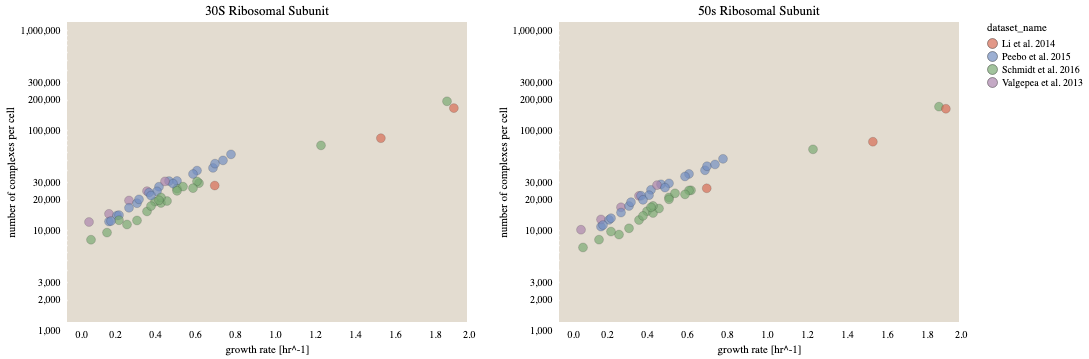

In [13]:
small_sub = complex_count[complex_count['complex']=='CPLX0-3953']
large_sub = complex_count[complex_count['complex']=='CPLX0-3962']
small_base = alt.Chart(small_sub)
large_base = alt.Chart(large_sub)

small_individuals = small_base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of complexes per cell'}, scale={'type':'log'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='30S Ribosomal Subunit')
large_individuals = large_base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of complexes per cell'}, scale={'type':'log'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='50s Ribosomal Subunit')
fig = small_individuals | large_individuals 
# fig.save('../../figures/f1f0_atp_synthase.html')
fig

##  Sugar transporters

Using the GO term GO:0046323  which is assigned to proteins with putative Glucose import function

In [14]:
pts_system_complexes = ['CPLX-157', 'ASCF-MONOMER', 'CPLX-165']
tporters = complex_count[complex_count['complex'].isin(pts_system_complexes)].groupby(
    ['dataset_name', 'condition', 'growth_rate_hr', 'complex']).mean().reset_index()
tporters = tporters[tporters['complex'].isin(pts_system_complexes)].groupby(
    ['dataset_name', 'condition', 'growth_rate_hr']).sum().reset_index()
tporters['n_units'] = np.round(tporters['n_units'].values)

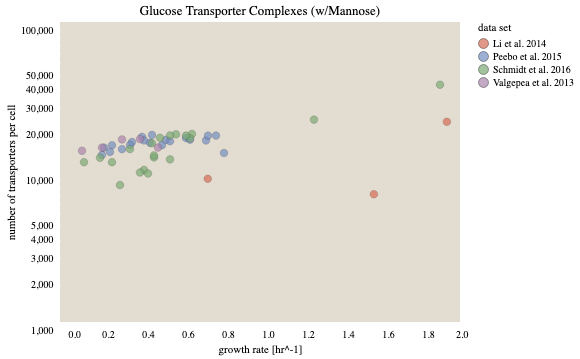

In [15]:
base = alt.Chart(tporters).mark_point(size=60)
min_complex_plot = alt.Chart(tporters).mark_point(size=60).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of transporters per cell'}, scale={'type':'log'}),
            fill=alt.Color('dataset_name:N',legend={'title':'data set'}),
            tooltip=['condition', 'dataset_name', 'growth_rate_hr', 'n_units'],
            strokeWidth=alt.value(0.2)).properties(title='Glucose Transporter Complexes (w/Mannose)').interactive()

min_complex_plot.save('../../figures/glucose_transporters.html')
min_complex_plot

    ## Sigma Factors

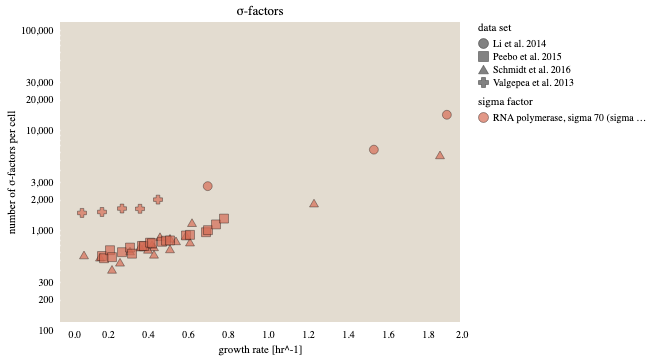

In [17]:
sigma_factor_complexes = ['rpod'] #'rpoe', 'feci', 'flia','rpoh','rpon', 'rpod', 'rpos']
sigma_factors = subunits[subunits['gene_name'].str.lower().isin(sigma_factor_complexes)]
sigma_factors_sum = subunits[subunits['gene_name'].str.lower().isin(
                            sigma_factor_complexes)
                            ].groupby(['dataset_name', 
                                       'condition', 
                                       'growth_rate_hr']).sum().reset_index()
indiv_plot = alt.Chart(sigma_factors).mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of σ-factors per cell'}, scale={'type':'log'}),
            shape=alt.Shape('dataset_name:N',legend={'title':'data set'}),
            fill=alt.Color('gene_product:N', legend={'title':'sigma factor'}),
            tooltip=['condition', 'dataset_name', 'growth_rate_hr', 'n_units'],
            strokeWidth=alt.value(0.5)).properties(title='σ-factors')
indiv_plot 



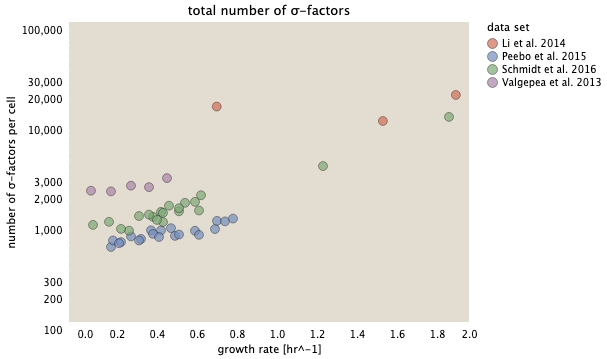

In [17]:
tot_plot = alt.Chart(sigma_factors_sum).mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of σ-factors per cell'}, scale={'type':'log'}),
            fill=alt.Color('dataset_name:N',legend={'title':'data set'}),
            tooltip=['condition', 'dataset_name', 'growth_rate_hr', 'n_units'],
            strokeWidth=alt.value(0.5)).properties(title='total number of σ-factors')
tot_plot

## Fatty Acid Synthesis 

In [20]:
fabs = subunits[subunits['gene_name']=='fabA']
alt.Chart(fabs).mark_point(size=80).encode(
        x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
        y=alt.Y('n_units:Q', axis={'title':'number of FAS units'}),
        fill=alt.Color('gene_name', legend={'title':'gene'}),
        shape=alt.Shape('dataset_name', legend={'title':'data set'}),
        strokeWidth=alt.value(0.2)
).interactive()

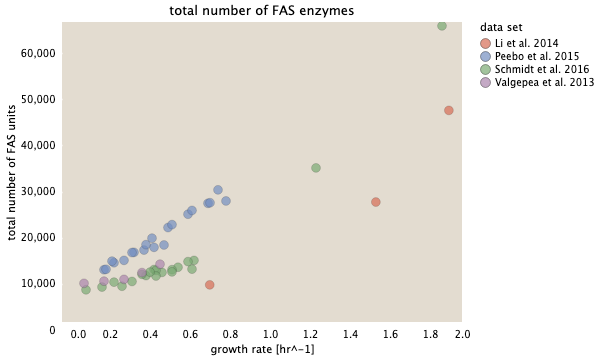

In [19]:
fabs_tot = subunits[subunits['gene_name'].str.contains('fab')].groupby(['dataset_name', 'condition', 'growth_rate_hr']).sum().reset_index()
alt.Chart(fabs_tot).mark_point(size=80).encode(
        x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
        y=alt.Y('n_units:Q', axis={'title':'total number of FAS units'}),
        fill=alt.Color('dataset_name', legend={'title':'data set'}),
        strokeWidth=alt.value(0.2)
).interactive().properties(title='total number of FAS enzymes')

## tRNA Synthesis

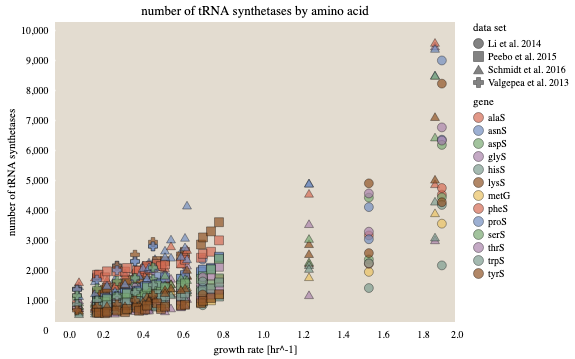

In [41]:
tRNA_prots = ['args', 'cyss', 'glns', 'gltx', 
              'iles', 'leus', 'vals', 'alas',
              'asns', 'asps', 'tyrs', 'trps',
              'thrs', 'sers', 'pros', 'phes',
              'metg', 'lyss', 'hiss', 'glys']
tRNA_syns = subunits[subunits['gene_name'].str.lower().isin(tRNA_prots)]
alt.Chart(tRNA_syns).mark_point(size=80).encode(
        x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
        y=alt.Y('n_units:Q', axis={'title':'number of tRNA synthetases'}),
        fill=alt.Color('gene_name:N', legend={'title':'gene'}),
        shape=alt.Shape('dataset_name:N', legend={'title':'data set'}),
        strokeWidth=alt.value(0.5)
).interactive().properties(title='number of tRNA synthetases by amino acid')

In [42]:
alt.Chart(tRNA_syns).mark_point(size=80).encode(
        x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
        y=alt.Y('sum(n_units):Q', axis={'title':'number of tRNA synthetases'}),
        fill=alt.Color('dataset_name:N', legend={'title':'data set'}),
        strokeWidth=alt.value(0.5)
).interactive().properties(title='Average Number of tRNA Synthetases')

la Stoichiometries

## Proton Pumps

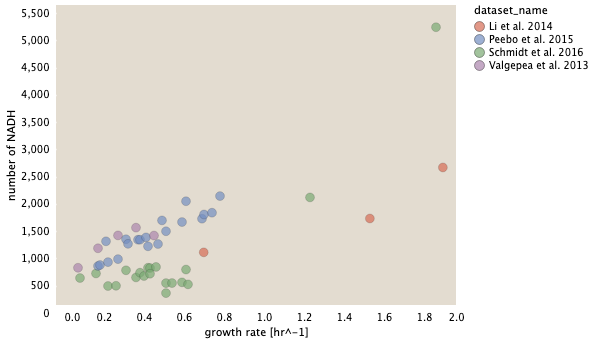

In [22]:
nadh = subunits[subunits['complex'] == 'NADH-DHI-CPLX'].groupby(['growth_rate_hr', 'dataset_name', 'condition'])['n_units'].mean().reset_index()
alt.Chart(nadh).mark_point(size=80).encode(
        x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
        y=alt.Y('n_units:Q', axis={'title':'number of NADH'}),
        fill='dataset_name:N',
        strokeWidth=alt.value(0.2)
).interactive()